# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

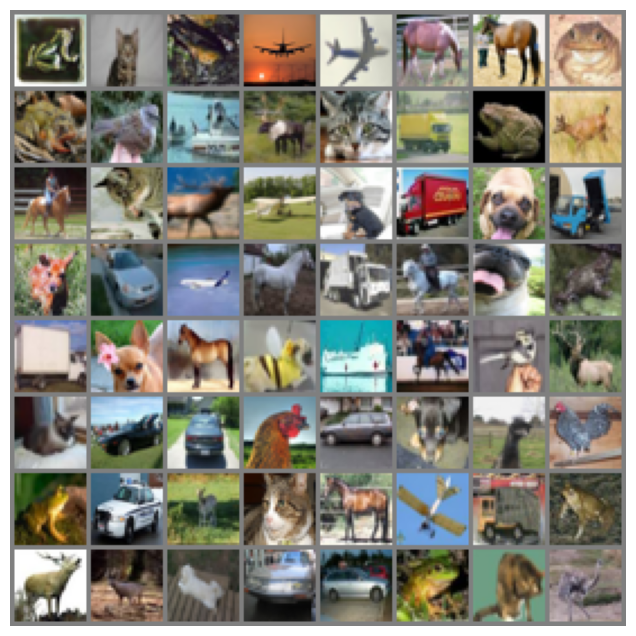

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Output: [B, 32, 32, 32]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: [B, 32, 32, 32]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # Output: [B, 32, 16, 16]

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # Output: [B, 64, 8, 8]

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Output: [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # Output: [B, 128, 4, 4]
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x


model = Model(n_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model.to(device)
print(model)

Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128,

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!

learning_rate = 1e-3  # Change this
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Your code here! ## Accuracy 0.72
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#### Comment
Since CIFAR-10 is a multi-class classification problem with 10 classes, the most suitable loss function is Cross-Entropy Loss. 
I'll start with Adam optimizer, as it is more adaptive and it requires less fine-tuning. 

Adding weight_decay in the optimizer can act as L2 regularization, which helps prevent overfitting:

 If the model is not converging or if the loss is oscillating wildly, try reducing the learning rate (e.g., 1e-4). If convergence is slow, try increasing it slightly (e.g., 1e-2).

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.14078814  0.40838295  0.29353    -0.2963362  -0.6119565  -0.59414726
  -0.2066682  -0.08778139 -0.17213413  0.5036173 ]
 [-0.34085062  0.02073684 -0.1690133  -0.23329693  0.04621515  0.05901592
   0.2817288   0.50337964 -0.24846971  0.34624767]]
Output probabilities:
[[0.08884064 0.15385573 0.13716196 0.07604279 0.05546076 0.05645733
  0.08317644 0.09367684 0.08609903 0.16922846]
 [0.06677547 0.09586331 0.07929485 0.07435788 0.09833713 0.09960403
  0.12445141 0.15533222 0.07323818 0.13274556]]


In [8]:
batch_size = 64
num_epochs = 10
validation_every_steps = 1000

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        output = model(inputs)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 1000    training accuracy: 0.6328125
             test accuracy: 0.6647
Step 2000    training accuracy: 0.7186783256880734
             test accuracy: 0.7043
Step 3000    training accuracy: 0.7625668960244648
             test accuracy: 0.7613
Step 4000    training accuracy: 0.8149305555555556
             test accuracy: 0.7933
Step 5000    training accuracy: 0.8401988636363636
             test accuracy: 0.8094
Step 6000    training accuracy: 0.8551865494296578
             test accuracy: 0.8132
Step 7000    training accuracy: 0.8699806787634409
             test accuracy: 0.8257
Finished training.


#### Base model
##### Experiment 1
- Learning rate: 1e-3
- Optimizer: Adam  
- Momentum: /
- Number of Epochs: 10
- Regularization: /
- Test Accuracy: 82.5 %
- Class accuracy: Truck 93% and Bird 63% 

##### Experiment 2
- Learning rate: 1e-3
- Optimizer: Adam
- Momentum: /
- Number of Epochs: 16
- Regularization: /
- Test Accuracy: 81.2 %
- Class accuracy: Truck 90% and Bird 67%

##### Experiment 3
- Learning rate: 1e-3
- Optimizer: SGD
- Momentum: 0.9
- Number of Epochs: 10
- Regularization: /
- Test Accuracy: 78.7 %
- Class accuracy: Auto 86% and cat 50%

##### Experiment 4
- Learning rate: 1e-2
- Optimizer: Adam
- Momentum: /
- Number of Epochs: 10
- Regularization: L2 0.1
- Test Accuracy: 72.0 %
- Class accuracy: Auto 86% and cat 50%



## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

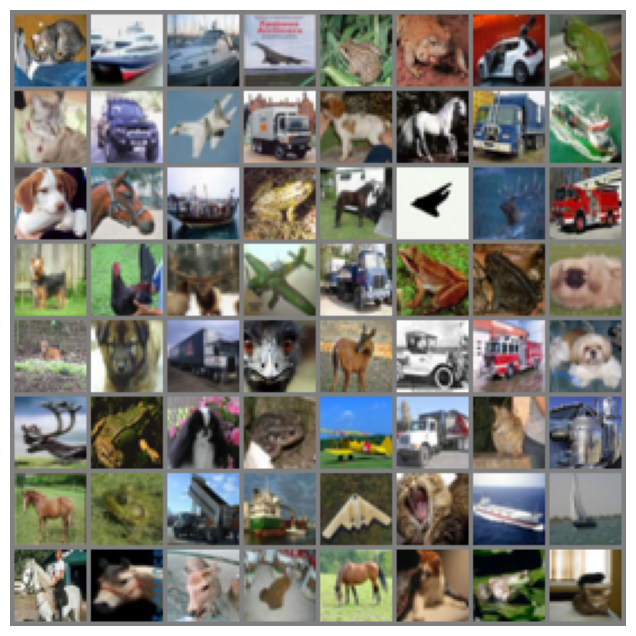

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship       automobile  
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          horse    
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         truck    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          bird     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog          fr

In [9]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [10]:
# Define the number of classes
n_classes = 10  # Make sure this matches your dataset

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        labels=list(range(n_classes)),  # Ensure all classes are included
        normalize=normalize
    )

# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=False).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [11]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.817


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


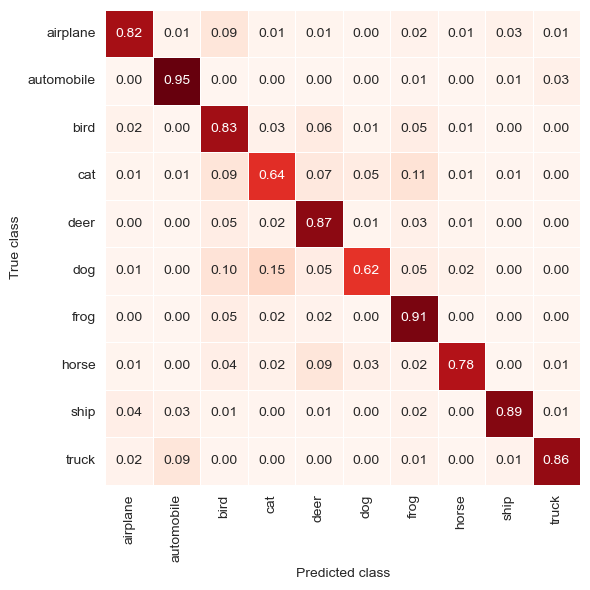

In [12]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

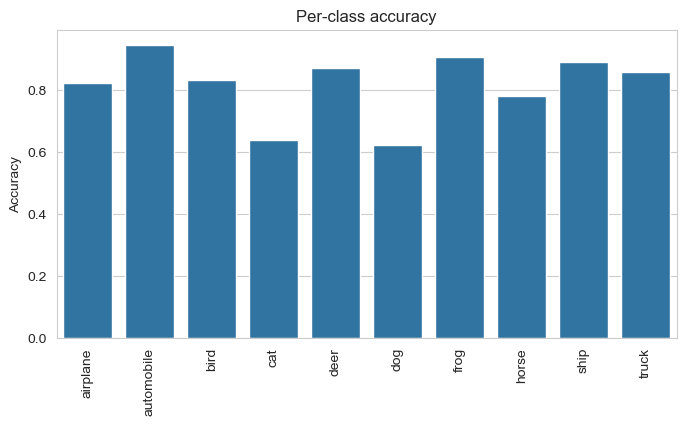

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**


# Introduction
In this assignment, I developed and trained a convolutional neural network (CNN) to classify images from the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes. The initial goal was to achieve a test accuracy of at least 70%. Through iterative experimentation and optimization, I was able to achieve a test accuracy of 82.5%. Below, I will describe the current model in detail, discuss the modifications made to improve its performance, and share the insights gained during this exercise.

## Detailed Layer Structure of Starting Model

### 3 Convolutional Blocks: General Structure
- `Conv2D`
- `BatchNorm2d`
- `ReLU`
- `MaxPool2d`

This sequence is repeated for each of the three convolutional blocks.

### Fully Connected Layers
- Flatten Layer
- Linear Layer (Fully Connected)
- ReLU Activation
- Dropout
- Linear Layer (Output)

### Loss Function and Optimizer
- **Loss Function:** CrossEntropyLoss
- **Optimizer:** Adam optimizer with a learning rate of 0.001

**Test Accuracy: 78.5%**

## Detailed Layer Structure of Best Model

### 3 Convolutional Blocks: Enhanced Structure
- `Conv2D`
- `BatchNorm2d`
- `ReLU`
- `Conv2D`
- `BatchNorm2d`
- `ReLU`
- `MaxPool2d`

This enhanced sequence is repeated for each of the three convolutional blocks.

### Fully Connected Layers
- Flatten Layer
- Linear Layer (Fully Connected)
- ReLU Activation
- Dropout
- Linear Layer (Output)

### Loss Function and Optimizer
- **Loss Function:** CrossEntropyLoss
- **Optimizer:** Adam optimizer with a learning rate of 0.001

**Test Accuracy: 82.5%**

## Experimentation and Results
To improve the performance of the initial model, I conducted several experiments by modifying the network architecture, optimizer settings, and training parameters.

### Experiment 1: Adding Additional Convolutional Layers
- **Modification:** Added a second `Conv2D`, `BatchNorm2d`, and `ReLU` in each convolutional block.
- **Result:** Test accuracy improved from 78.5% to 82.5%.
- **Observation:** The additional layers allowed the model to learn more intricate patterns and hierarchical features from the images.

### Experiment 2: Adjusting Learning Rate and Optimizer
- **Learning Rate:** Tested learning rates of 0.001 and 0.01.
  - A learning rate of 0.001 yielded better results.
  - A higher learning rate of 0.01 led to unstable training and did not improve performance.
- **Optimizer:** Compared Adam and SGD with momentum.
  - Adam optimizer consistently provided better results than SGD with momentum.
  - SGD achieved a test accuracy of around 78.7%, while Adam reached 82.5%.

### Experiment 3: Increasing Number of Epochs
- **Epochs Tested:** 10 and 16 epochs.
- **Result:** Training beyond 10 epochs did not yield significant improvements.
  - At 16 epochs, the test accuracy was 81.2%, slightly less than at 10 epochs.
- **Observation:** The model began to overfit after 10 epochs, as indicated by the plateauing or slight decrease in test accuracy.

### Experiment 4: Implementing Regularization
- **L2 Regularization (Weight Decay):**
  - Applied weight decay of 0.1 in the optimizer.
  - **Result:** Did not improve performance; in some cases, it reduced test accuracy.
- **Dropout:**
  - Added a Dropout layer with a rate of 0.5 after the first fully connected layer.
  - **Result:** Helped stabilize training and slightly improved test accuracy.


## Observations and Surprises
- **Additional Convolutional Layers Boosted Performance:** Adding more convolutional layers significantly improved the model's ability to capture complex features, leading to better performance.
- **Optimizer Choice Matters:** The Adam optimizer outperformed SGD with momentum in this context, likely due to its adaptive learning rates facilitating faster convergence.
- **Learning Rate Sensitivity:** The model was sensitive to the choice of learning rate. A too-high learning rate caused instability, while a lower rate improved convergence.
- **Regularization Effects:** Heavy L2 regularization did not improve performance, suggesting that overfitting was not a significant issue with the current model and dataset.
- **Diminishing Returns with More Epochs:** Training beyond a certain number of epochs led to overfitting rather than improved performance.

## Key Lessons
- **Model Depth and Complexity:** Increasing the depth of the network by adding more layers can significantly enhance performance, but it also raises computational costs and the risk of overfitting. It's crucial to find a balance.
- **Hyperparameter Tuning is Crucial:** The choice of optimizer and learning rate profoundly impacts the training process. Adaptive optimizers like Adam can yield better results without extensive tuning.
- **Regularization Techniques Should Be Used Judiciously:** While regularization can prevent overfitting, over-regularizing can hinder the model's learning capacity. Techniques like Dropout can be more effective when overfitting is observed.
- **Importance of Experimentation:** Systematic experimentation with different configurations is essential to understand how various changes affect performance.



## Conclusion
Through iterative experimentation, I successfully improved the CNN's test accuracy on the CIFAR-10 dataset from 78.5% to 82.5%. The most significant improvements came from adding additional convolutional layers to deepen the network and fine-tuning the optimizer and learning rate. This exercise highlighted the importance of model architecture design, hyperparameter tuning, and the need for careful analysis of results to make informed adjustments


# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [14]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce RTX 3060 Laptop GPU']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





Exercise from chapter 3, on page 92:

<em>
    As discussed above, one way of expanding the MNIST training data is to use small
    rotations of training images. What’s a problem that might occur if we allow arbitrarily
    large rotations of training images?
</em>

**Answer:**

If we rotate a '9' by 180 degrees, it looks like a '6', as such the network might learn a model that associates '9'='6', or just converge to a really bad model that has around 50% chance of predicting a 9 or a 6.